# PENCIL Tutorial in Python

## Introduction 
In this tutorial, we will demonstrate how to use PENCIL on the scanpy/anndata objects in Python. The package `pencil` is developed in Python, so it is more natural to integrate `scanpy` with PENCIL pipeline. We also apply PENCIL on the two simulated datasets in R-tutorial to learn phenotype associated ceel subpopulations for categorical and continuous phenotypes, respectively.

## 0. Installation
If you haven't install the `pencil`, you can run the following magic command in this jupyter notebook. In this tutorial, the `scanpy` pacakage is required, you can also install it here if needed. 

In [ ]:
%pip install -e ..
%pip install scanpy

Then, let's import the required packages:

In [49]:
from pencil import *
import scanpy as sc
from matplotlib.colors import LinearSegmentedColormap

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' #select a gpu id, otherwise set to '-1'.

import warnings
warnings.filterwarnings('ignore') #to ignore warnings on the output. 

## PENCIL examples
For convenience, we convert seurat objects to '.h5ad' files and then load them into scanpy/anndata objects. The data download and conversion steps are included in the r script `data_download.R`, so if you have not downloaded the data yet, run the change script in R.
```
source('ata_download.R') #R
```


### Apply PENCIL's multi-classification mode

#### Load data to scanpy

In [50]:
adata = sc.read_h5ad('./data/Feldman_T_cell_data_simulation.h5ad')
mvg2000 = pd.read_csv('./data/Feldman_T_cell_data_simulation_mvg2000_list.csv')
mvg2000 = mvg2000['x']
adata = adata[:, mvg2000]
print(adata)

View of AnnData object with n_obs × n_vars = 6350 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'original_clustering', 'responsive_status', 'RNA_snn_res.0.8', 'seurat_clusters', 'true_groups_simulation', 'cell_phenotype_labels_simulation'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap', 'X_umap-mvg2000'
    varm: 'PCs'
    obsp: 'distances'


Visualize the condition labels on the UMAP from top 2000 most variable genes (MVG2000), 

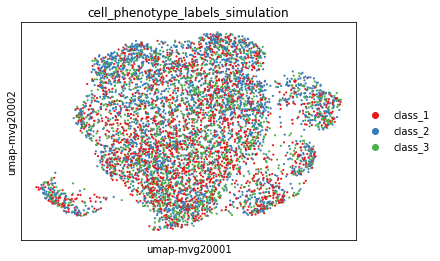

In [51]:
colors = sns.color_palette('Set1')
num_classes = len(set(adata.obs.cell_phenotype_labels_simulation.values))
pal=colors[0:num_classes]
pal.insert(0, colors[-1]) #add grey

sc.pl.embedding(adata, 'umap-mvg2000', color=['cell_phenotype_labels_simulation'], palette=pal[1:], frameon=True)

The cell labels of the simulated data were actually generated based on the expression level clustering of MVG1000-1300 (ground truth genes, GT genes). Clusters 0, 2, and 9 are used as ground truth groups (GT groups), and in each ground truth group, 90% of the cells are set to be in the same class, and the remaining 10% are randomly assigned other class labels to simulate phenotype enriched subpopulations. The other cells are randomly assigned a class label as background interference.

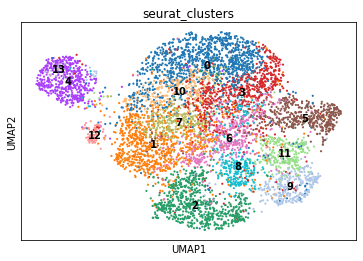

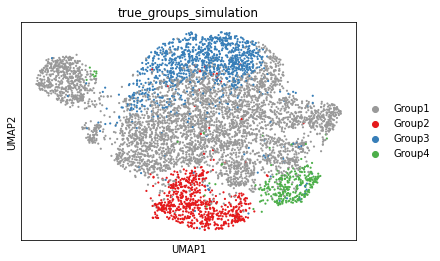

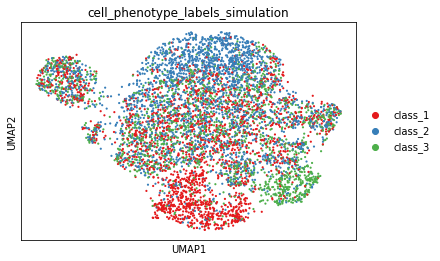

In [52]:
adata.obs.seurat_clusters = pd.Categorical(adata.obs.seurat_clusters)
sc.pl.umap(adata, color='seurat_clusters', frameon=True, legend_loc='on data')

sc.pl.umap(adata, color='true_groups_simulation', palette=pal, frameon=True)
sc.pl.umap(adata, color='cell_phenotype_labels_simulation', palette=pal[1:], frameon=True)

#### Excute PENCIL

Prepare the source data for `pencil`. PENCIL takes as input a matrix of expression data from MVG2000 (or more genes) and cell labels in an attempt to simultaneously localize GT genes and the cell subpopulations from which they arise.

In [53]:
labels_raw = adata.obs.cell_phenotype_labels_simulation
labels_raw = pd.Categorical(labels_raw)
data, labels = adata.X.copy(), labels_raw.codes
class_names = list(labels_raw.categories)
emd = adata.obsm['X_umap']

print(data.shape)
print(labels.shape)
print(class_names)
print(emd.shape)

(6350, 2000)
(6350,)
['class_1', 'class_2', 'class_3']
(6350, 2)


Run `pencil` with mlflow recording, and show the results directly by passing parameter `emd`. We present the results on the UMAP generated from GT genes to facilitate comparison with the GT group.

Experiment 'Feldman_T_sim' already exists.
dataset: Feldman_T_sim, expr_id: 0.0.1
scheme: ce, Sigmoid
searching c...
cmin:0.000, cmax:2.000, c:1.000, rejected 0 cells.
cmin:0.000, cmax:1.000, c:0.500, rejected 3595 cells.
cmin:0.000, cmax:0.500, c:0.250, rejected 6249 cells.
cmin:0.250, cmax:0.500, c:0.375, rejected 4516 cells.
cmin:0.250, cmax:0.375, c:0.312, rejected 5646 cells.
cmin:0.250, cmax:0.312, c:0.281, rejected 5896 cells.
cmin:0.281, cmax:0.312, c:0.297, rejected 5791 cells.
searched c: 0.296875
pretrain 500 epochs...
cuda is available.
epoch=0, loss=0.3839, mean_e=0.4755, mean_r=-0.0433, L1_reg=21.3151
epoch=20, loss=0.3407, mean_e=0.4753, mean_r=-0.5820, L1_reg=27.6287
epoch=40, loss=0.3403, mean_e=0.4758, mean_r=-0.6453, L1_reg=27.5444
epoch=60, loss=0.3381, mean_e=0.4769, mean_r=-0.6720, L1_reg=31.8403
epoch=80, loss=0.3362, mean_e=0.4787, mean_r=-0.5779, L1_reg=36.8966
epoch=100, loss=0.3337, mean_e=0.4812, mean_r=-0.4753, L1_reg=43.5172
epoch=120, loss=0.3320, mean_e=

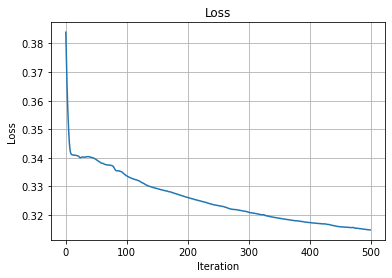

---train time: 9.305238008499146 seconds ---

Number of examples rejected= 4363 / 6350
num_of_rejcted
class_2           1514
class_3           1433
class_1           1416
dtype: int64
--- without rejection ---
              precision    recall  f1-score   support

     class_1       0.62      0.46      0.53      2115
     class_2       0.52      0.76      0.62      2463
     class_3       0.52      0.36      0.42      1772

    accuracy                           0.55      6350
   macro avg       0.55      0.52      0.52      6350
weighted avg       0.55      0.55      0.53      6350

--- with rejection ---
              precision    recall  f1-score   support

     class_1       0.92      0.94      0.93       699
     class_2       0.94      0.96      0.95       949
     class_3       0.94      0.85      0.90       339

    accuracy                           0.93      1987
   macro avg       0.93      0.92      0.92      1987
weighted avg       0.93      0.93      0.93      1987



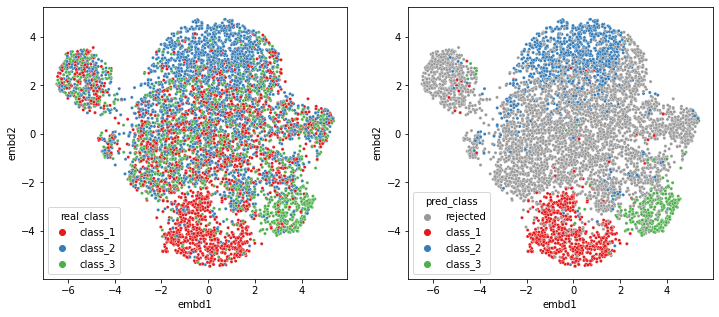

---test time: 1.5525219440460205 seconds ---


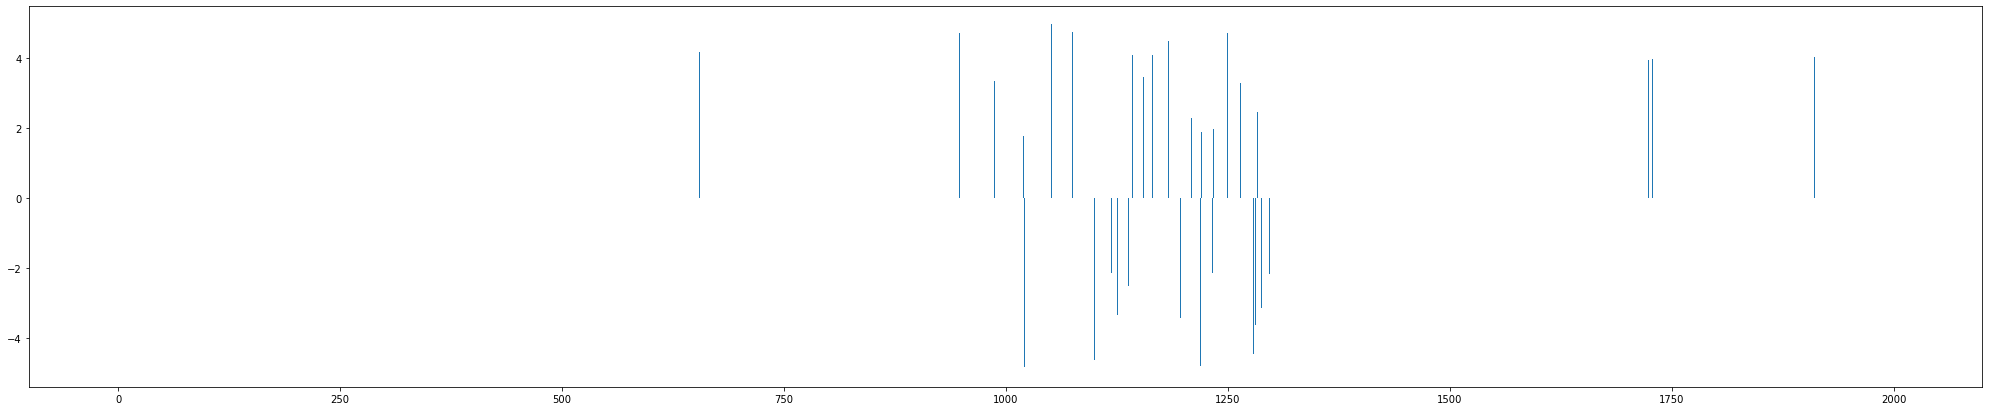

In [54]:
data_name = 'Feldman_T_sim'
expr_id = '0.0.1'

mode = 'multi-classification'
pencil = Pencil(mode, select_genes=True, seed=1234, data_name=data_name, expr_id=expr_id, mlflow_record=True)
with mlflow.start_run():
    pred, confidence = pencil.fit_transform(
        data, labels, 
        test=True, 
        shuffle_rate=1/4,
        lambda_L1=1e-5, 
        lambda_L2=1e-3, 
        lr=0.01,  
        class_weights=None,
        class_names=class_names, 
        emd=emd,
        plot_show=True
        )
    w = pencil.gene_weights(plot=True)
    plt.close()

The labels predicted by PENCIL are almost identical to the ground truth! Moreover, by visualizing the gene weights learned by PENCIL, we can see that the selected genes are indeed also mostly located in the range of mvg1000-1300 (GT genes). 

After the run is complete, execute `mlflow ui` in the terminal to view the results of each experiment and compare them conveniently. <br>

#### Show results with scanpy

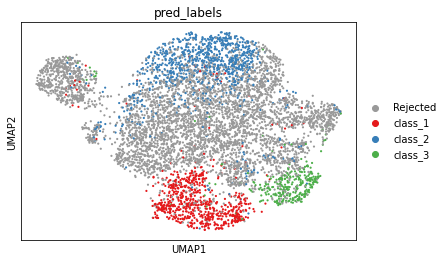

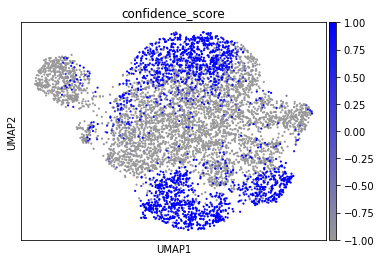

In [55]:
pred_labels = np.array(labels_raw.categories[pred])
pred_labels[confidence < 0] = 'Rejected'
adata.obs['pred_labels'] = pred_labels
adata.obs['confidence_score'] = confidence

sc.pl.umap(adata, color='pred_labels', palette=pal)
sc.pl.umap(
    adata, color='confidence_score', 
    color_map=LinearSegmentedColormap.from_list('mymap', [colors[-1], 'blue'])
    )

### Apply PENCIL's regression mode

#### Load data to scanpy

The features of the second example are 10 principle components (PCs).

In [56]:
adata_2 = sc.read_h5ad('./data/DAseq_tutorial_data_simulation.h5ad')
pcs_list = pd.read_csv('./data/DAseq_tutorial_data_simulation_pcs_list.csv')
pcs_list = pcs_list['x']
adata_2 = adata_2[:, pcs_list]
print(adata_2)

View of AnnData object with n_obs × n_vars = 16291 × 10
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'phenotyp_info', 'RNA_snn_res.1', 'seurat_clusters', 'true_groups_simulation', 'cell_timepoints_simulation'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_umap'
    obsp: 'distances'


Visualize the timepoints labels on the UMAP from top 10 PCs.

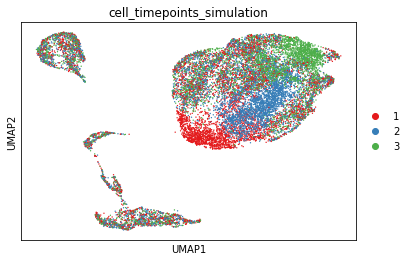

In [57]:
adata_2.obs.cell_timepoints_simulation = pd.Categorical(adata_2.obs.cell_timepoints_simulation)
pal=colors[0:len(set(adata_2.obs.cell_timepoints_simulation.values))]
sc.pl.umap(adata_2, color='cell_timepoints_simulation', palette=pal, frameon=True)

Visualize the ground truth setting. The simulated timepoint labels are still obtained from the clustering results, but since the input is 10-PCs-matrix, we do not set the ground truth feature like the first example. Theoretically, we can also perform simultaneous feature selection in regression mode (more related results can be found in our paper).

The clusters 3, 1, 2, 11, 4 are set to the ground truth groups (GT groups). For cells in GT groups 1, 3, and 5, we assign timepoints 1, 2, 3, respectively. For cells in GT groups 2, 4, we assign the time points of the pre- and post-groups in a 1:1 ratio to simulate transition states. The other cells are still randomly assigned a timepoint label as background noise.

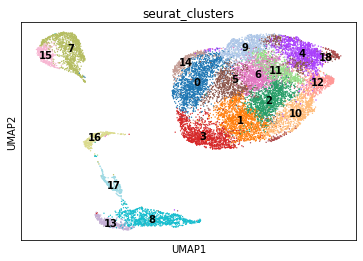

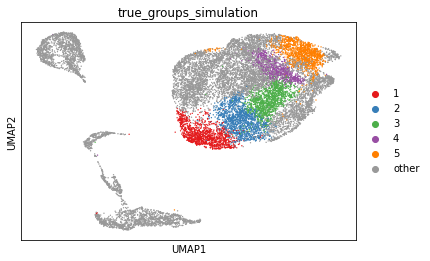

In [58]:
adata_2.obs.seurat_clusters = pd.Categorical(adata_2.obs.seurat_clusters)
sc.pl.umap(adata_2, color='seurat_clusters', frameon=True, legend_loc='on data')

pal=colors[0:(len(set(adata_2.obs.true_groups_simulation.values)) - 1)]
pal.append(colors[-1])
sc.pl.umap(adata_2, color='true_groups_simulation', palette=pal, frameon=True)

#### Excute PENCIL
Extract the PCs-matrix and timepoints labels for PENCIL.

In [59]:
data = adata_2.X.copy().todense()
labels = np.array(adata_2.obs.cell_timepoints_simulation.values, dtype=float)
emd = adata_2.obsm['X_umap']

print(data.shape)
print(labels)
print(emd.shape)

(16291, 10)
[3. 3. 3. ... 1. 3. 3.]
(16291, 2)


Run `pencil`.

Experiment 'DAseq_tutorial_sim' already exists.
dataset: DAseq_tutorial_sim, expr_id: 0.0.1
scheme: sml1, NGLR
searching c...
cmin:0.000, cmax:2.000, c:1.000, rejected 0 cells.
cmin:0.000, cmax:1.000, c:0.500, rejected 435 cells.
cmin:0.000, cmax:0.500, c:0.250, rejected 12803 cells.
cmin:0.000, cmax:0.250, c:0.125, rejected 16291 cells.
cmin:0.125, cmax:0.250, c:0.188, rejected 16291 cells.
cmin:0.188, cmax:0.250, c:0.219, rejected 13823 cells.
cmin:0.188, cmax:0.219, c:0.203, rejected 16291 cells.
searched c: 0.203125
cuda is available.
epoch=0, loss=1.4097, mean_e=1.4376, mean_r=-0.0138, L1_reg=1.9475
epoch=20, loss=0.4060, mean_e=1.3665, mean_r=-0.9981, L1_reg=2.5915
epoch=40, loss=0.4060, mean_e=1.3257, mean_r=-0.9978, L1_reg=2.6782
epoch=60, loss=0.4056, mean_e=1.3122, mean_r=-0.9956, L1_reg=2.6811
epoch=80, loss=0.4029, mean_e=1.2962, mean_r=-0.9751, L1_reg=2.6590
epoch=100, loss=0.3941, mean_e=1.1739, mean_r=-0.9250, L1_reg=2.6933
epoch=120, loss=0.3709, mean_e=0.9510, mean_r=-

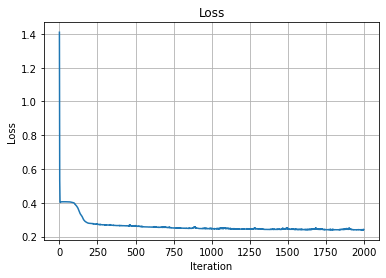

---train time: 22.939072847366333 seconds ---

Number of examples rejected= 10214 / 16291


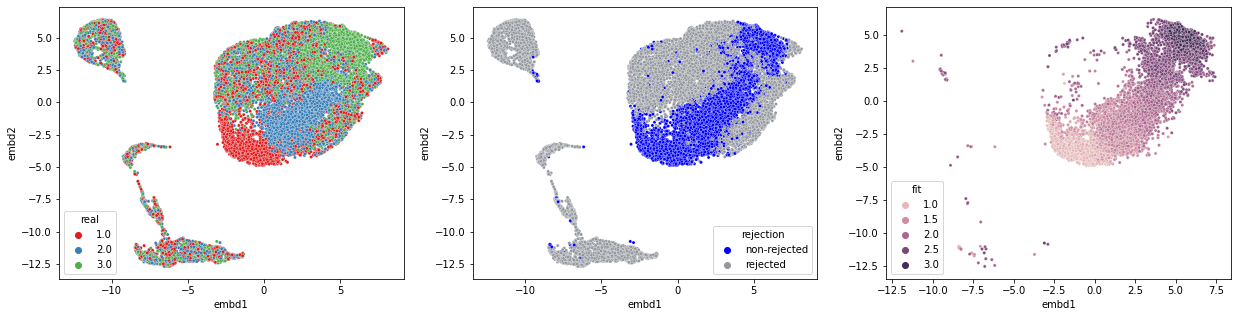

---test time: 3.886336088180542 seconds ---


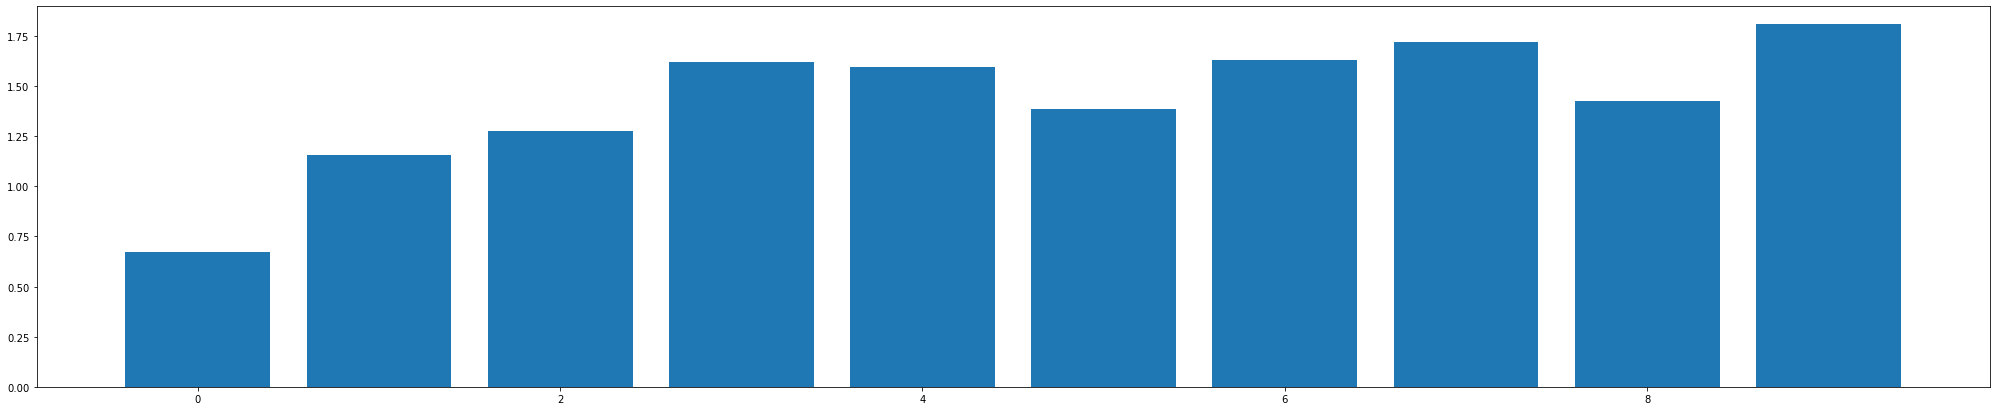

In [60]:
data_name = 'DAseq_tutorial_sim'
expr_id = '0.0.1'
mode = 'regression'
pencil = Pencil(mode, select_genes=True, seed=1234, data_name=data_name, expr_id=expr_id, mlflow_record=True, dropouts=[0.0, 0.0]) #`select_genes` can also be set to False, if True, pencil will output a weight vector for all 10 PCs. 
with mlflow.start_run():
    pred, confidence = pencil.fit_transform(
        data, labels, 
        test=True,
        shuffle_rate=1/5,
        lambda_L1=1e-5, 
        lambda_L2=0.0, 
        lr=0.01, 
        epochs=2000, 
        class_weights=None,
        emd=emd,
        plot_show=True
        )

The distribution of the continuous time scores predicted by PENCIL match well with the ground truth and successfully identify the transition states. 

#### Show results with scanpy

Adding the pencil’s results into the anndata object to visualize.

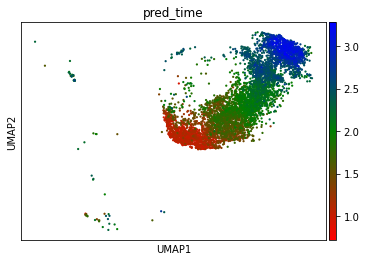

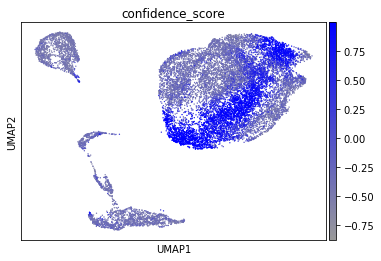

In [61]:
adata_2.obs['pred_time'] = pred
adata_2.obs['confidence_score'] = confidence
sc.pl.umap(
    adata_2[confidence>0, ], color='pred_time', 
    color_map=LinearSegmentedColormap.from_list('mymap_', ['red', 'green', 'blue'])
    )
sc.pl.umap(
    adata_2, color='confidence_score', 
    color_map=LinearSegmentedColormap.from_list('mymap', [colors[-1], 'blue'])
    )

## Referrence
Supervised learning of high-confidence phenotypic subpopulations from single-cell data (2022).

Tao Ren, Lingyun Wu and Zheng Xia